# CS-6600 Assignment 3 - Classification

**YOUR NAME HERE**

*Weber State University*

For this assignment, we'll be examining the age-old question of "Alpaca or Not?". Specifically, we'll be building a classification tool to make this call, and then evaluating the performance of that tool.
<center>
    <div>
        <img src="https://drive.google.com/uc?export=view&id=14m05vDDiZhfQnqda5NAGhFQgiUYxNyDY" width = 300/>
    </div>
</center>

We'll use a dataset consisting of many images of Alpacas and many images of not Alpacas (you know giraffes, bears, etc...). So first, we'll need to grab the dataset. I've got it stored on my Google Drive as a .zip file, and you can download it and unzip it within your local environment.

Now let's import the libraries we'll need.

In [1]:
#The Usual Suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Some deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

#Some libraries for downloading and unzipping files
import gdown
import zipfile

#For creating a dataset from image libraries
from keras.preprocessing import image_dataset_from_directory

#For generating our metrics
from sklearn.metrics import auc, RocCurveDisplay, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

### Getting The Data

The code below should create an alpacas.zip file in your local directory, and then a folder called "dataset". Within "dataset" there should be two folders: "alpaca" and "not alpaca". The first contains images of alpacas, while the second contains images of, you guessed it, not alpacas. You should only need to run this import once.

In [2]:
url = 'https://drive.google.com/uc?id=1dkkeAYexofzOSliLiHviLMtdXsV1t3wa'
output = 'alpacas.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile('./alpacas.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Downloading...
From (original): https://drive.google.com/uc?id=1dkkeAYexofzOSliLiHviLMtdXsV1t3wa
From (redirected): https://drive.google.com/uc?id=1dkkeAYexofzOSliLiHviLMtdXsV1t3wa&confirm=t&uuid=502011fb-5c84-4381-a8b1-49887799ffbc
To: /content/alpacas.zip
100%|██████████| 122M/122M [00:03<00:00, 32.3MB/s]


We'll now create and training and validation datasets using the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function from Keras. We'll create two datasets - a training dataset, and a *validation* dataset. We'll discuss what these mean in more detail later. Note that it's important to use the same random seed (in this case 6600) for these datasets. Otherwise, you might get overlap.

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=6600)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=6600)

inference_dataset = image_dataset_from_directory(directory,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.
Found 327 files belonging to 2 classes.


We can check out the labels assigned to the images. These were determined by the folder names.

In [4]:
class_names = train_dataset.class_names
class_names

['alpaca', 'not alpaca']

Let's take a look at some of the images:

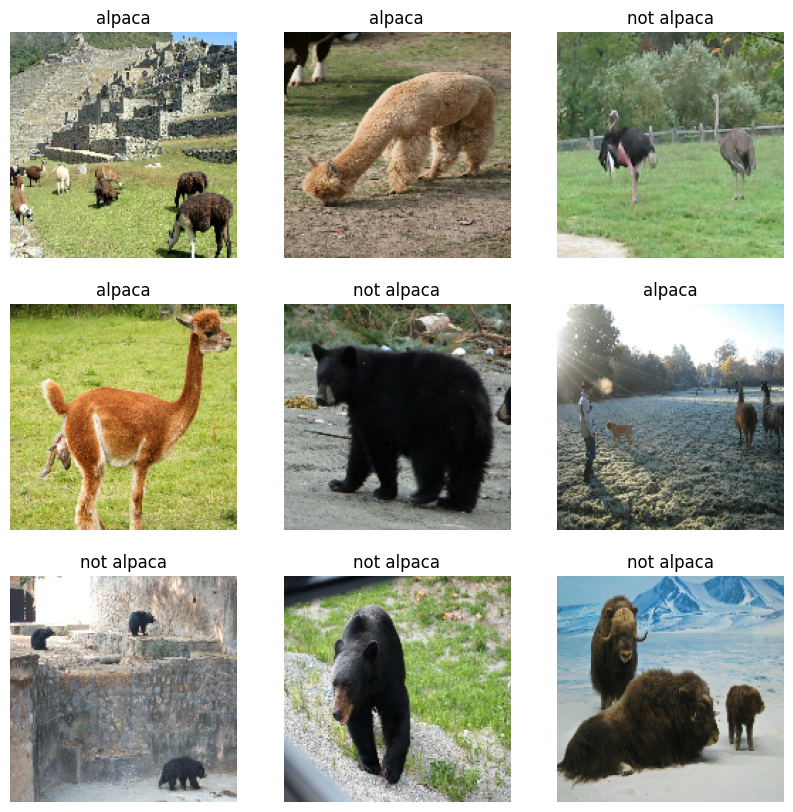

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## A (Relatively) Simple Model

If we try to learn these with a *very* simple model, we're gonna have a bad time. So, we'll use a *relatively* simple model, but one far more advanced that the first ones we'll be investigating in this class.

That's OK. All we really want to do here is investigate how we'd measure the success of this model, and we don't need to understand exactly what it's doing in order to do that.

So, what we'll do below is build a simple convolutional neural network, that will output a binary classification ("llama or not") for our problem.

In [6]:
inputs = keras.Input(shape=(160, 160, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

We'll now compile the model you created. Again, no need to worry about the details yet.

In [7]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop")

Now we need to train the model. This may take a minute.

In [8]:
model.fit(train_dataset, epochs = 10);

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.9909
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.6918
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.8819
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.6963
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.6846
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.6849
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.6757
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.7158
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.6280
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.6071


## Assessing The Model's Performance

So, how well does this model do? First, let's create an array of the model's predictions on the training dataset. We can do this with the *model.predict* method.

In [9]:
y_pred = model.predict(inference_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step


This has now run the prediction model on the training data, and created an array of those predictions. However, we'll want to flatten it into a single dimension, so let's do that first, and then take a look at it (just the first ten elements):

In [10]:
y_pred = y_pred.flatten()

In [11]:
y_pred[:10]

array([0.4983747 , 0.36891228, 0.26260224, 0.5102206 , 0.51492965,
       0.49787617, 0.8403994 , 0.50241566, 0.543673  , 0.5039246 ],
      dtype=float32)

Now, let's grab the actual labels from our dataset.

In [12]:
label_list = []
for _, labels in inference_dataset:
  label_list.append(labels.numpy())
y_true = np.concatenate(label_list)
#Note - This isn't a particularly Pythonic way to do it, but I think it's clearer.

We'll take a look at this array as well. Note that it starts with all the Alpacas, and then follows that with all the non-Alpacas.

In [13]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Let's now create an array of actual predictions ("Alpaca or not") from our probabilities:

In [14]:
y_pred_classes = np.round(y_pred).astype(int)

Now *y_pred_classes* are a bunch of $0$s and $1$s as well.

In [15]:
y_pred_classes

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

Now it's your turn. Let's assess how good this model was. First, what was the accuracy score?

In [99]:
#YOUR CODE HERE
accuracy = accuracy_score(y_true, y_pred_classes)
print("The Accuracy score: " + str(accuracy))
accuracy = accuracy_score(y_true, y_pred_classes, normalize=False)
print("Number of correct predictions: " + str(accuracy))

#END CODE

The Accuracy score: 0.6024464831804281
Number of correct predictions: 197


##Accuracy, Precision, Recall, ROC explain to a 6 year old
###If you add to pick apples out of a basket that had oranges:
**Accuracy**: Of all the fruits you picked, how many are apples and not oranges  
**Precision**: When you picked an fruit, how often was it a apple  
**Recall**: Of all the Apples in the basket, how many apples did you get?


###Spam email vs regualr emails
**Accuracy**: How often did you model corrctly select spam and not spam  
Why: how often is it making the right prediction, but no info about the type of mistakes.  
  
    
**Precision**: of all emails your model predicted spam, how often was it correct?  
Why: if you get a high precision, that means you model is correctly not labeling normal or important emails as spam  
  
**Recall**: Of all the spam emails, how many did you model correctly identify as spam?  
Why: If it high recall, it means your model is good at catching almost all spam, even if it mistakes mistakes regular email for spam (false Postive)

Next, what is the precision?

In [25]:
# YOUR CODE HERE How well did it do in it prediction in the postive class or when it predicts a postive.
# True Postive / True Postive + False Postive

precision = precision_score(y_true, y_pred_classes)
print("The Precision score: " + str(precision))
# END CODE

The Precision score: 0.6255707762557078


What is the recall?

In [26]:
# YOUR CODE HERE Out of the postive class, how well did you model perform, or the percentage of the actuall positve values.
# True Positive / True Positive + False Negitive

recall = recall_score(y_true, y_pred_classes)
print("The Recall score: " + str(recall))

# END CODE

The Recall score: 0.7405405405405405


Create the confusion matrix.

[[ 60  82]
 [ 48 137]]


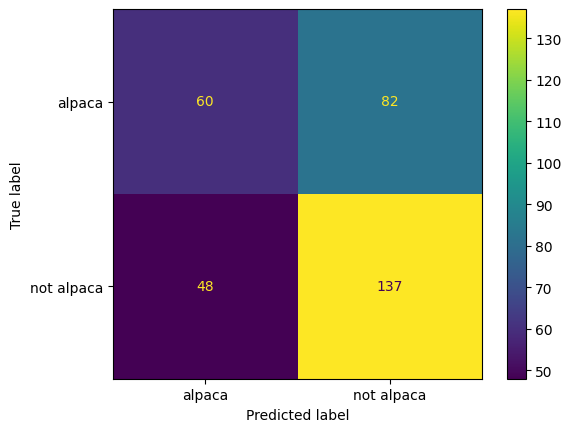

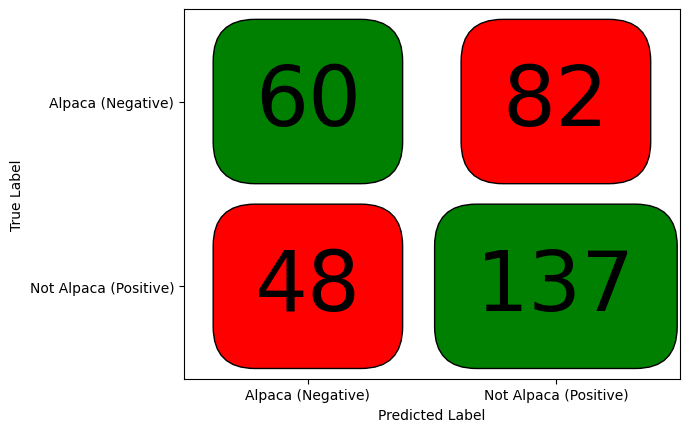

In [98]:
# YOUR CODE HERE
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)


# EXTRA STUFF, just experminting

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()
plt.show()

cm = confusion_matrix(y_true, y_pred_classes)
labelsX = "Alpaca (Negative)", "Not Alpaca (Positive)"
labelsY = "Not Alpaca (Positive)", "Alpaca (Negative)"

colormap = np.array([["Green", "red"],
                 ["red", "Green"]])


fig, ax = plt.subplots()

plt.text(0, 1, f'{cm[0,0]}', ha='center', va='center', fontsize=60, bbox=dict(facecolor=colormap[0, 0], edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(1, 1, f'{cm[0,1]}', ha='center', va='center', fontsize=60, bbox=dict(facecolor=colormap[0, 1], edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(0, 0, f'{cm[1,0]}', ha='center', va='center', fontsize=60, bbox=dict(facecolor=colormap[1, 0], edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(1, 0, f'{cm[1,1]}', ha='center', va='center', fontsize=60, bbox=dict(facecolor=colormap[1, 1], edgecolor='black', boxstyle='round,pad=0.5'))


plt.xlabel('Predicted Label')
plt.ylabel('True Label')


ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xticks([0, 1], labels=labelsX)
ax.set_yticks([0, 1], labels=labelsY)

plt.show()

# END CODE

Finally, draw the ROC curve for this model.

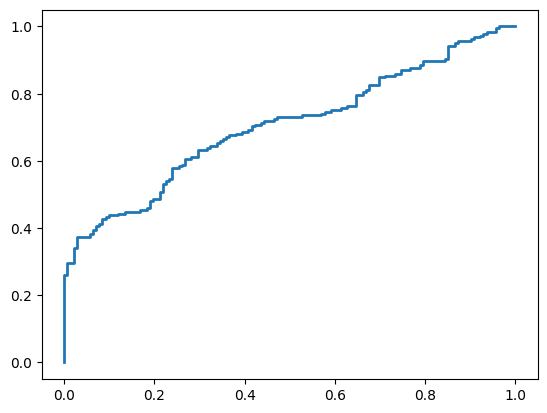

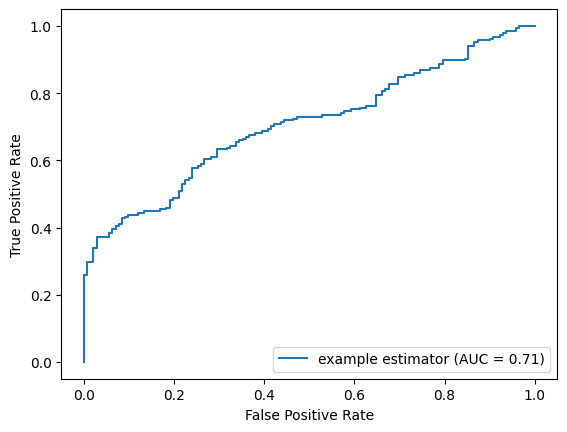

In [97]:
#YOUR CODE HERE
falsePostiveRate, truePostiveRate, thresholds = roc_curve(y_true, y_pred)

#Based on lecture 5 example
plt.plot(falsePostiveRate, truePostiveRate, linewidth=2, label="ROC curve")


# Experimenting
roc_auc = auc(falsePostiveRate, truePostiveRate)
display = RocCurveDisplay(fpr=falsePostiveRate, tpr=truePostiveRate, roc_auc=roc_auc,
                                  estimator_name='example estimator')

display.plot()
plt.show()

#END CODE

And, calculate it's AUC score.

In [96]:
#YOUR CODE HERE
aucScore = roc_auc_score(y_true, y_pred)
print("AUC (Area Under Curve) Is: " + str(aucScore))
#END CODE

AUC (Area Under Curve) Is: 0.7057480015226495


The model we've built here is not very good. That's OK. We might have a later assignment where we look at ways we can improve it.

For this assignment, you should upload your modified Jupyter notebook to Canvas.

<center>
    <div>
        <img src="https://drive.google.com/uc?export=view&id=1jjV9teAyrbNFDB1o8shMLpD6CrrllxWa" width = 300/>
    </div>
</center>